<a href="https://colab.research.google.com/github/utkarsh-mishra19/pytorch/blob/main/sarcasm_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers --quiet
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/rmisra/news-headlines-datkaset-for-sarcasm-detection")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: k
Your Kaggle Key: ··········
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection


100%|██████████| 3.30M/3.30M [00:00<00:00, 625MB/s]

In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
device = 'cuda'if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [12]:
data_df = pd.read_json("/content/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json",lines=True)
data_df.dropna(inplace=True)
data_df.drop_duplicates(inplace=True)
data_df.drop(["article_link"],inplace = True,axis = 1)
data_df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [14]:
x_train,x_test,y_train,y_test = train_test_split(np.array(data_df['headline']),np.array(data_df['is_sarcastic']),test_size = 0.3)
x_test,x_val,y_test,y_val = train_test_split(x_test,y_test,test_size = 0.5)
print(len(x_train),len(x_test),len(x_val))

18695 4006 4007


In [15]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = AutoModel.from_pretrained("google-bert/bert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [20]:
class Data(Dataset):
  def __init__(self,x,y):
    self.X = [tokenizer(
        text,max_length =100,truncation = True,
        padding = "max_length",
        return_tensors = 'pt').to(device)
    for text in x]
    self.Y = torch.tensor(y,dtype = torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self,idx):
    return self.X[idx],self.Y[idx]

train_data = Data(x_train,y_train)
test_data = Data(x_test,y_test)
val_data = Data(x_val,y_val)

In [21]:
train_dataloader = DataLoader(train_data,batch_size = 32,shuffle = True)
test_dataloader = DataLoader(test_data,batch_size = 32,shuffle = True)
val_dataloader = DataLoader(val_data,batch_size = 32,shuffle = True)

In [25]:
class model(nn.Module):
  def __init__(self,bert):
    super(model,self).__init__()
    self.bert = bert
    self.dropout = nn.Dropout(0.25)
    self.linear1 = nn.Linear(768,384)
    self.linear2 = nn.Linear(384,1)
    self.sigmoid = nn.Sigmoid()

  def forward(self,input_ids,attention_mask):
    pooled_output = self.bert(input_ids,attention_mask,return_dict=False)[0][:,0]
    output = self.linear1(pooled_output)
    output = self.dropout(output)
    output = self.linear2(output)
    output = self.sigmoid(output)
    return output

In [26]:
for param in bert_model.parameters():
  param.requires_grad = False
model = model(bert_model).to(device)


In [27]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(),lr = 1e-5)


In [30]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []
for epoch in range(10):
  total_loss_train = 0
  total_acc_train = 0
  total_loss_val = 0
  total_acc_val = 0
  for index,data in enumerate(train_dataloader):
    inputs,labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    predection = model(inputs['input_ids'].squeeze(1),inputs['attention_mask'].squeeze(1)).squeeze(1)
    batchloss = criterion(predection,labels)
    total_loss_train+=batchloss.item()
    acc = (predection.round()==labels).sum().item()
    total_acc_train+=acc
    batchloss.backward()
    optimizer.step()
    optimizer.zero_grad
  with torch.no_grad():
    for index,data in enumerate(val_dataloader):
      inputs,labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      predection = model(inputs['input_ids'].squeeze(1),inputs['attention_mask'].squeeze(1)).squeeze(1)
      batchloss = criterion(predection,labels)
      total_loss_val+=batchloss.item()
      acc = (predection.round()==labels).sum().item()
      total_acc_val+=acc
  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_val_plot.append(round(total_loss_val/1000,4))
  total_acc_train_plot.append(round(total_acc_train/train_data.__len__()*100,4))
  total_acc_val_plot.append(round(total_acc_val/val_data.__len__()*100,4))
  print(f'''Epoch no. {epoch + 1} Train Loss: {round(total_loss_train/1000,4)} Train Accuracy: {round(total_acc_train/(train_data.__len__())*100,4)} Validation Loss: {round(total_loss_val/100,4)} Validation Accuracy: {round(total_acc_val/(val_data.__len__())*100,4)}''')
  print("="*50)

Epoch no. 1 Train Loss: 0.2219 Train Accuracy: 83.0971 Validation Loss: 0.4895 Validation Accuracy: 82.9548
Epoch no. 2 Train Loss: 0.2128 Train Accuracy: 84.0011 Validation Loss: 0.4779 Validation Accuracy: 83.454
Epoch no. 3 Train Loss: 0.2156 Train Accuracy: 84.0492 Validation Loss: 0.5127 Validation Accuracy: 82.4557
Epoch no. 4 Train Loss: 0.2124 Train Accuracy: 84.1829 Validation Loss: 0.477 Validation Accuracy: 83.6536
Epoch no. 5 Train Loss: 0.2039 Train Accuracy: 84.6109 Validation Loss: 0.4362 Validation Accuracy: 84.4522
Epoch no. 6 Train Loss: 0.2004 Train Accuracy: 85.242 Validation Loss: 0.4416 Validation Accuracy: 84.6768
Epoch no. 7 Train Loss: 0.1975 Train Accuracy: 84.8997 Validation Loss: 0.4723 Validation Accuracy: 84.028
Epoch no. 8 Train Loss: 0.1973 Train Accuracy: 85.3437 Validation Loss: 0.467 Validation Accuracy: 83.9032
Epoch no. 9 Train Loss: 0.1955 Train Accuracy: 85.5095 Validation Loss: 0.4643 Validation Accuracy: 84.003
Epoch no. 10 Train Loss: 0.194 Tra

In [31]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for index,data in enumerate(test_dataloader):
      inputs,labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      predection = model(inputs['input_ids'].squeeze(1),inputs['attention_mask'].squeeze(1)).squeeze(1)
      batchloss = criterion(predection,labels)
      total_loss_test+=batchloss.item()
      acc = (predection.round()==labels).sum().item()
      total_acc_test+=acc

  print(f'''Test Loss: {round(total_loss_test/1000,4)} Test Accuracy: {round(total_acc_test/(test_data.__len__())*100,4)}''')


Test Loss: 0.0446 Test Accuracy: 84.4733


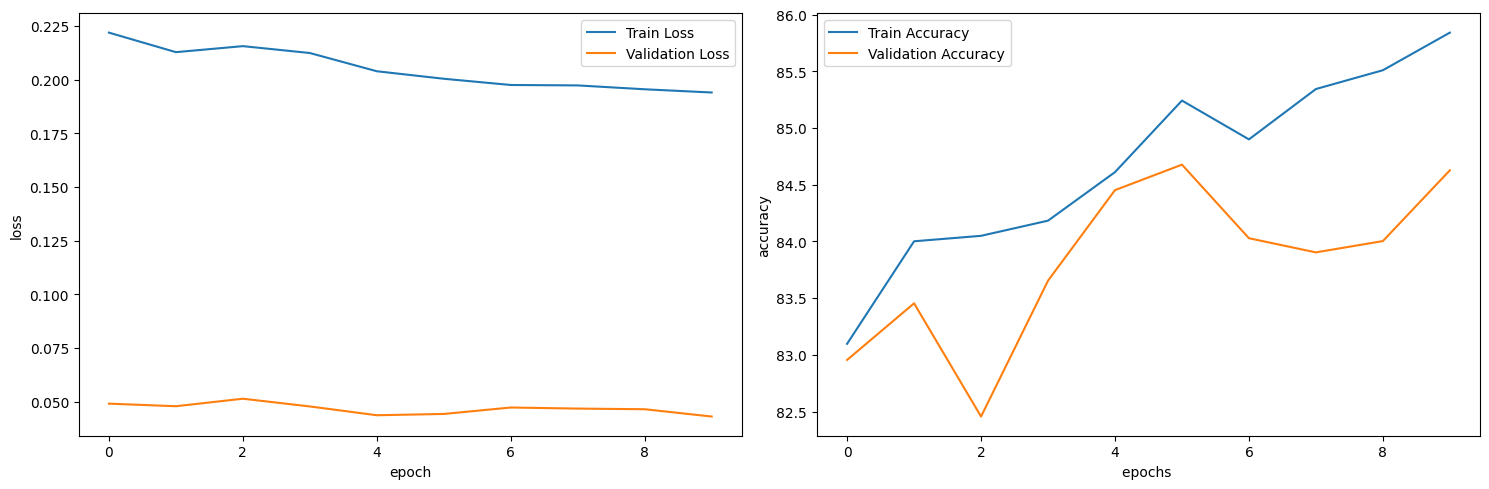

In [33]:
fig, axs = plt.subplots(nrows = 1,ncols = 2,figsize = (15,5))
axs[0].plot(total_loss_train_plot,label = 'Train Loss')
axs[0].plot(total_loss_val_plot,label = 'Validation Loss')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot,label = 'Train Accuracy')
axs[1].plot(total_acc_val_plot,label = 'Validation Accuracy')
axs[1].set_xlabel('epochs ')
axs[1].set_ylabel('accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()